In [ ]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3  #it for if dataset in database to load we use sqlite3
#import pandas as pd  #pandas library
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [ ]:
df=pd.read_csv('/content/Reviews.csv')
df.shape
#df.head(10)
def partition(x):
  if x<3:
    return 0
  return 1

filtered_data=df[df['Score']!=3]
filtered_data.head(10)
actual_score=filtered_data['Score']
positivenegative=actual_score.map(partition)
filtered_data['Score']=positivenegative
filtered_data.head(10)
filtered_data.shape
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape
final=final[final['HelpfulnessNumerator']<=final['HelpfulnessDenominator']]
final['Score'].value_counts()
sent_4900=final['Text'].values[4900]
print(sent_4900)
print("="*50)



Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [ ]:
#TEXT PREPROCESSING
nltk.download('stopwords')
stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')
#print(sno.stem('tasty'))
def cleanhtml(sentence):
  cleanr=re.compile('<*?>')
  cleantext=re.sub(cleanr,'',sentence)
  return cleantext

def cleanpunc(sentence):
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned

def decontracted(phrase):    #stackoverflow
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

    
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


from tqdm import tqdm # tqdm is for printing the status bar
i=0
str1=' '
preprocessed_reviews=[]
all_positive_words=[] #store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''

for sentance in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sentance)
    sentance=cleanhtml(sentance)#removing the html tags
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    for w in sentance.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stopwords):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values[i]) == 1 :
                      all_positive_words.append(s) #list all the positive words
                    if (final['Score'].values[i]) == 0 :
                       all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    preprocessed_reviews.append(str1.strip())
    i+=1










[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 364171/364171 [08:22<00:00, 724.61it/s]


In [ ]:
#print(stop)
type(preprocessed_reviews)
final['preprocessed_reviews']=preprocessed_reviews
final['preprocessed_reviews']=final['preprocessed_reviews'].str.decode("utf-8")
#final.head(10)
all_negative_words[0:10]
final.to_csv('preprocessed_data.csv',index=False)
new_df=pd.read_csv('preprocessed_data.csv')
new_df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud nice rhythm well g...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
5,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,1,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",charm rhyme book describ circumst eat not chic...
6,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,1,1338249600,Must have.,I set aside at least an hour each day to read ...,set asid least hour day read son point consid ...
7,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,rememb book childhood got kid good rememb kid ...
8,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,1,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....,great book ador illustr true classic kid love ...
9,150515,0006641040,A2RTT81R6Y3R7X,Lindylu,0,0,1,1303171200,One of our family's favorite books,This book is a family favorite and was read to...,book famili favorit read children small order ...


In [ ]:
X=final['preprocessed_reviews'].values
y=final['Score'].values

In [ ]:
print(X.shape)
print(y.shape)

(364171,)
(364171,)


In [ ]:
#splitting the data 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(254919,) (254919,)
(109252,) (109252,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
Vect=CountVectorizer()
X_train_Bow=Vect.fit_transform(X_train)
X_test_Bow=Vect.transform(X_test)
print(X_train_Bow.shape,y_train.shape)
print(X_test_Bow.shape,y_test.shape)

(254919, 49606) (254919,)
(109252, 49606) (109252,)


In [ ]:
X_train=X_train_Bow
X_test=X_test_Bow
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
import math
def gridsearch(X_train,y_train):
  cv=KFold(n_splits=5)
  alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
  model=MultinomialNB()
  parameters={'alpha':alpha_values}
  clf=GridSearchCV(model,parameters,scoring='roc_auc',cv=cv,return_train_score=True,verbose=1)
  clf.fit(X_train,y_train)
  new_clf=pd.DataFrame.from_dict(clf.cv_results_)
  new_clf.sort_values(['param_alpha'])
  best_alpha=clf.best_params_['alpha']
  score=clf.best_score_
  print(score)

  return best_alpha

best_alpha=gridsearch(X_train,y_train)
best_alpha
model=MultinomialNB(alpha=best_alpha)
model.fit(X_train,y_train)

  
   


Fitting 5 folds for each of 11 candidates, totalling 55 fits
0.9058265451860226


MultinomialNB(alpha=1)

In [ ]:
best_alpha=gridsearch(X_train,y_train)
best_alpha

Fitting 5 folds for each of 11 candidates, totalling 55 fits
0.9058265451860226


1

In [ ]:
from sklearn.metrics import roc_curve, auc

def test_data(X_train,y_train,X_test,y_test):
    model=MultinomialNB(alpha=best_alpha)
    model.fit(X_train, y_train)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    sns.set()
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
    plt.legend()
    plt.xlabel("False_positive_rate")
    plt.ylabel("True positive_rate")    
    plt.title("ROC_Curve")
    plt.grid()
    plt.show()
    print('The AUC_score of test_data is :',auc(test_fpr, test_tpr))

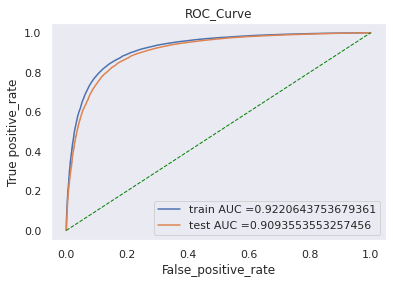

The AUC_score of test_data is : 0.9093553553257456


In [ ]:
test_data(X_train,y_train,X_test,y_test)